In [1]:
import pickle as pkl
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
tqdm.pandas()
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pickle
import nltk
from collections import Counter
sns.set_palette("colorblind")

## Hue as Dataset

In [2]:
pooling_path = "/zfs/projects/faculty/amirgo-management/code_review_data/pooling/"
df = pd.read_csv(pooling_path+'explicit_trend.csv')
df = df[df['year']>=1950]

/tmp/ipykernel_3674638/1435868940.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(pooling_path+'explicit_trend.csv')


In [3]:
def min_max_normalization(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

def gen_selected_label_proportions_doc_adj(df, label_col, values, doc_id='doc_id'):
    datasets = list(df['dataset'].unique())
    datasets.append('total')
    ds_proportions = []
    for dataset in datasets:
        if dataset != 'total':
            df_dataset = df[df['dataset'] == dataset]
        else:
            df_dataset = df
        # total unique docs
        total_docs = df_dataset.groupby('year')[doc_id].nunique().reset_index(name='total_docs')
        grouped = df_dataset.groupby(['year', label_col])[doc_id].nunique().reset_index(name='counts')
        grouped = grouped.pivot(index='year', columns=label_col, values='counts').reset_index()
        grouped['total_docs'] = total_docs['total_docs']
        for value in values:
            grouped[str(value)+'_prop'] = grouped[value]/grouped['total_docs']
            grouped[str(value)+'_prop_smooth'] =  grouped[str(value)+'_prop'].rolling(10, min_periods=1).mean()
            # normalize
            grouped[str(value)+'_prop_smooth_norm'] = min_max_normalization(grouped[str(value)+'_prop_smooth'])
        grouped['dataset'] = dataset
        ds_proportions.append(grouped)

    total_grouped = pd.concat(ds_proportions, axis=0, ignore_index=True)
    return total_grouped

# without doc adj (for each year, directly count the number of sentences)
def gen_selected_label_proportions(df, label_col, values, sentence_id='sentence_id'):
    datasets = list(df['dataset'].unique())
    datasets.append('total')
    print(datasets)
    ds_proportions = []
    for dataset in datasets:
        if dataset != 'total':
            df_dataset = df[df['dataset'] == dataset]
        else:
            df_dataset = df
        total_sents = df_dataset.groupby('year')[sentence_id].count().reset_index(name='total_sents')
        grouped = df_dataset.groupby(['year', label_col])[sentence_id].count().reset_index(name='counts')
        grouped = grouped.pivot(index='year', columns=label_col, values='counts').reset_index()
        grouped['total_sents'] = total_sents['total_sents']
        for value in values:
            grouped[str(value)+'_prop'] = grouped[value]/grouped['total_sents']
            grouped[str(value)+'_prop_smooth'] =  grouped[str(value)+'_prop'].rolling(10, min_periods=1).mean()
            # normalize
            grouped[str(value)+'_prop_smooth_norm'] = min_max_normalization(grouped[str(value)+'_prop_smooth'])
        grouped['dataset'] = dataset
        ds_proportions.append(grouped)
    
    total_grouped = pd.concat(ds_proportions, axis=0, ignore_index=True)
    return total_grouped

# plot different datasets with different hues
def plot_explicit_trend(ground_df, value, value_str):
    datasets = list(ground_df['dataset'].unique())
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    for dataset in datasets:
        df_dataset = ground_df[ground_df['dataset'] == dataset]
        # color blind palette
        color = sns.color_palette("colorblind", len(datasets))[datasets.index(dataset)]
        if dataset == 'total':
            ax.plot(df_dataset['year'], df_dataset[str(value)+'_prop_smooth_norm'], label=dataset, color=color, linewidth=4)
        else:
            ax.plot(df_dataset['year'], df_dataset[str(value)+'_prop_smooth_norm'], label=dataset, color=color, alpha=0.3)
    ax.legend()
    ax.set_xlabel('year')
    ax.set_ylabel('Normalized Proportion')
    ax.set_title("Normalized Proportion of "+value_str+" over Years")
    plt.show()

['congress', 'movie', 'caselaw', 'nyt', 'fiction', 'total']


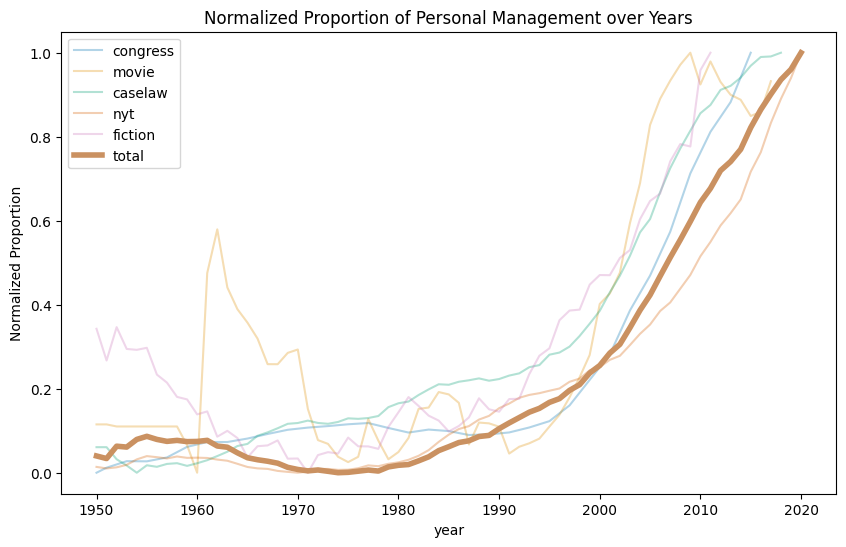

In [4]:
total_grouped = gen_selected_label_proportions(df, 'IsPerson',[1])
plot_explicit_trend(total_grouped, 1, 'Personal Management')

# Personal Management Composition

In [5]:
def collapse_label(label):
    if label in ['Financials']:
        return "Money"
    elif label in ['Emotion and subjective experiences']:
        return 'Subjectivity'
    elif label in ['Human body']:
        return 'Body'
    elif label in ['Family', 'Friendship', 'Romantic relationships']:
        return 'Relationship'
    elif label in ['Time']:
        return 'Time'
    elif label in ['Household']:
        return 'Household'
    else:
        return 'Others'

df['secondaryLabelSum'] = df['secondaryLabel'].apply(collapse_label)

In [6]:
dataset_size_dict = df['dataset'].value_counts().to_dict()
dataset_size_dict['total'] = len(df)

In [9]:
def decade_modifier_distribution_total_adj(df_personal, baseline_df):
    datasets = ['nyt','caselaw','congress','movie','fiction']
    datasets.append('total')
    dataset_proportions = []
    for dataset in datasets:
        if dataset != 'total':
            personal_dataset = df_personal[df_personal['dataset'] == dataset]
            baseline_df_dataset = baseline_df[baseline_df['dataset'] == dataset]
        else:
            personal_dataset = df_personal
            baseline_df_dataset = baseline_df

        category_decade = personal_dataset.groupby(['decade', 'secondaryLabelSum']).size().unstack().fillna(0)
        total_sent_decade = baseline_df_dataset.groupby('decade').size()
        category_decade_norm = category_decade.div(total_sent_decade, axis=0)
        dataset_proportions.append(category_decade_norm)

    # plot
    # number of subplots: 2 rows, 3 columns
    n_datasets = len(datasets)
    fig, ax = plt.subplots(2, 3, figsize=(20, 10))
    for i in range(n_datasets):
        category_decade_norm = dataset_proportions[i]
        ax_row = i // 3
        ax_col = i % 3
        category_decade_norm.plot(kind='bar', stacked=True, ax=ax[ax_row, ax_col])
        ax[ax_row, ax_col].set_xlabel('Decade')
        ax[ax_row, ax_col].set_ylabel('Proportion')
        ax[ax_row, ax_col].set_title(f'{datasets[i]} (n={dataset_size_dict[datasets[i]]})')
        ax[ax_row, ax_col].legend(title='Management Domains')
        ax[ax_row, ax_col].xaxis.set_tick_params(rotation=0)
    # plt.tight_layout()
    # overall title
    plt.suptitle('Proportion of Personal Management Domains over Decades', fontsize=16)
    return 

In [7]:
df_personal = df[df['IsPerson'] == 1].copy()
df_personal = df_personal[df_personal['secondaryLabelSum']!='Others']
df_personal['decade'] = df_personal['decade'].astype(int)

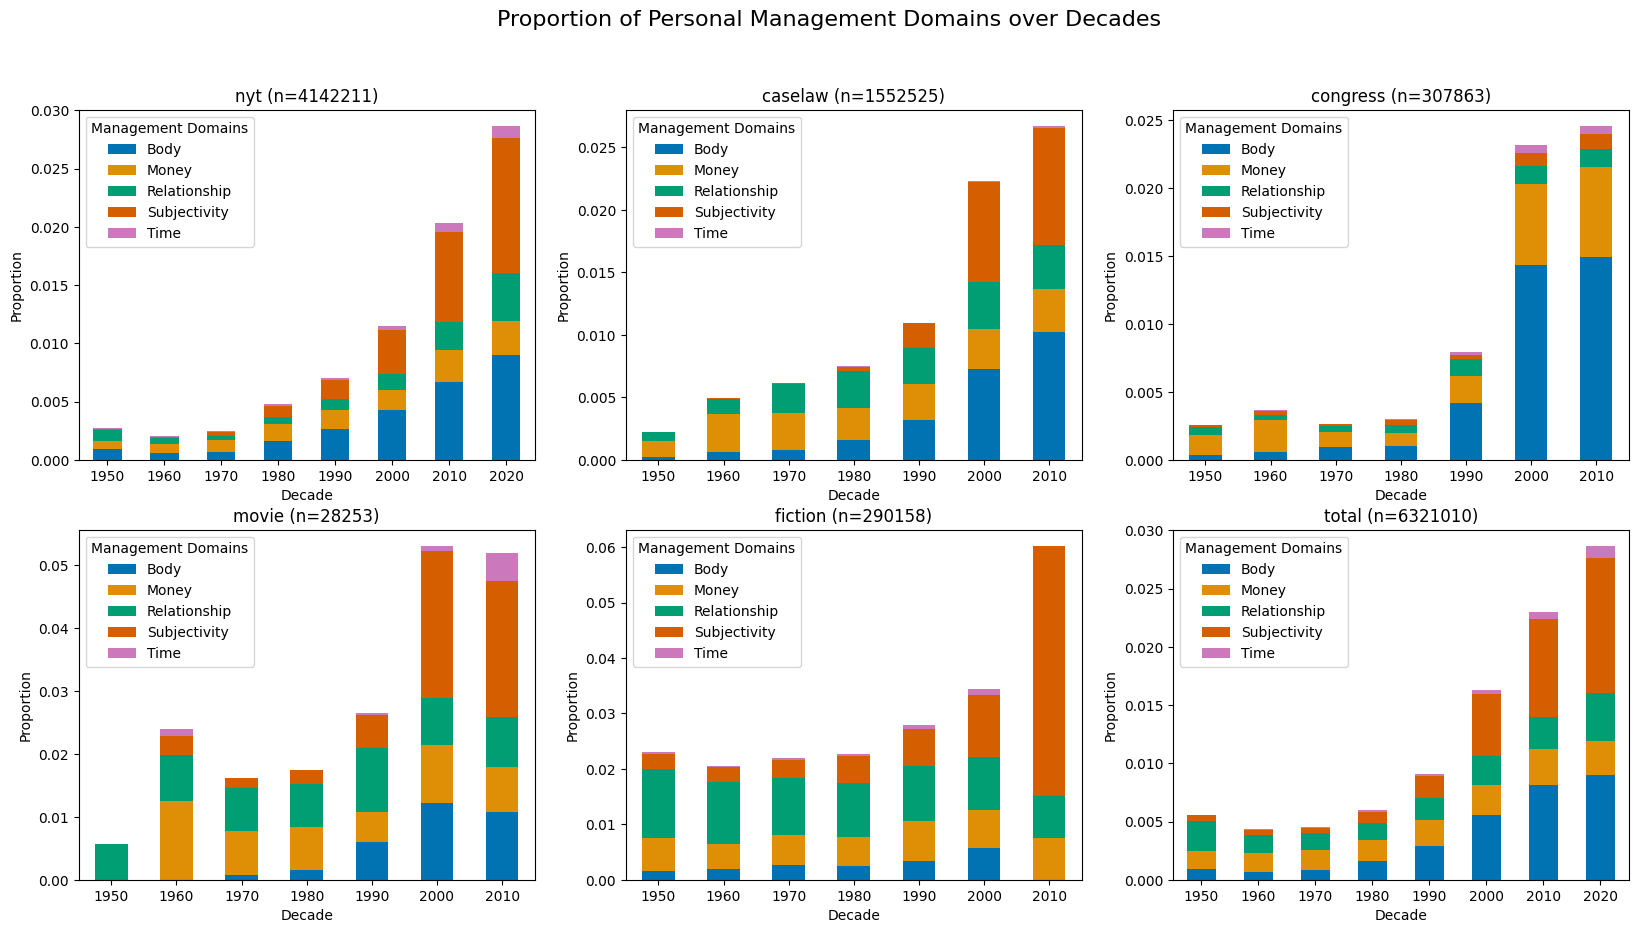

In [10]:
decade_modifier_distribution_total_adj(df_personal, df)